# Install requirements

Use **Python v3.8.10**, in a dedicated Virtual Environment.

In [ ]:
!python -m pip install -U pip
!pip install wheel
!pip install azureml-sdk[notebooks]
!pip install click matplotlib numpy opencv-python
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install -r ../src/yolov5/requirements.txt

# Import packages

In [25]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import glob as glob
import cv2

import azureml.core
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core import ScriptRunConfig
from azureml.core import Dataset
from azureml.data.datapath import DataPath
from azureml.core.environment import Environment

In [2]:
# Check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.41.0


# Connect to AzureML workspace

In [3]:
#ws = Workspace.get("ws-ngdg-explorations",subscription_id="35d018a1-fd64-4a56-91e9-75f463fbfd0d",resource_group="rg-ngdg-explorations")
#ws.write_config()
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

ws-ngdg-explorations	northeurope	rg-ngdg-explorations


### Configure experiment

In [4]:
experiment_name = 'yolov5_custom_training'
exp = Experiment(workspace=ws, name=experiment_name)

### Configure compute resources (CPU/GPU cluster)

In [5]:
# Choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "gpu-compute-k80")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 1)

# This example uses GPU VM.
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "Standard_NC6")

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes,
                                                                max_nodes = compute_max_nodes)

    # Create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

# Dataset

In [28]:
data_folder = os.path.join(os.getcwd(), 'soccer')
data_folder = "D:/Users/Gianni/Downloads/yolov5_gt_dataset"
os.makedirs(data_folder, exist_ok=True)

In [29]:
datastore = ws.get_default_datastore()

If not already done, upload the local dataset to the workspace:

In [ ]:
Dataset.File.upload_directory(src_dir=data_folder, target=DataPath(datastore, "datasets/yolov5_soccer"))

### Display some data

In [9]:
# Custom classes
class_names = [
    "unknown", "ball", "person"
]

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=6
        )
        cv2.putText(
            image,
            class_names[int(labels[box_num])],
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            3,
            (0, 255, 0),
            10
        )
    return image


# Function to plot images with bounding boxes
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    plt.figure(figsize=(21, 12))
    for i in range(num_samples):
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(4, 4, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.show()

Visualize a few training images:

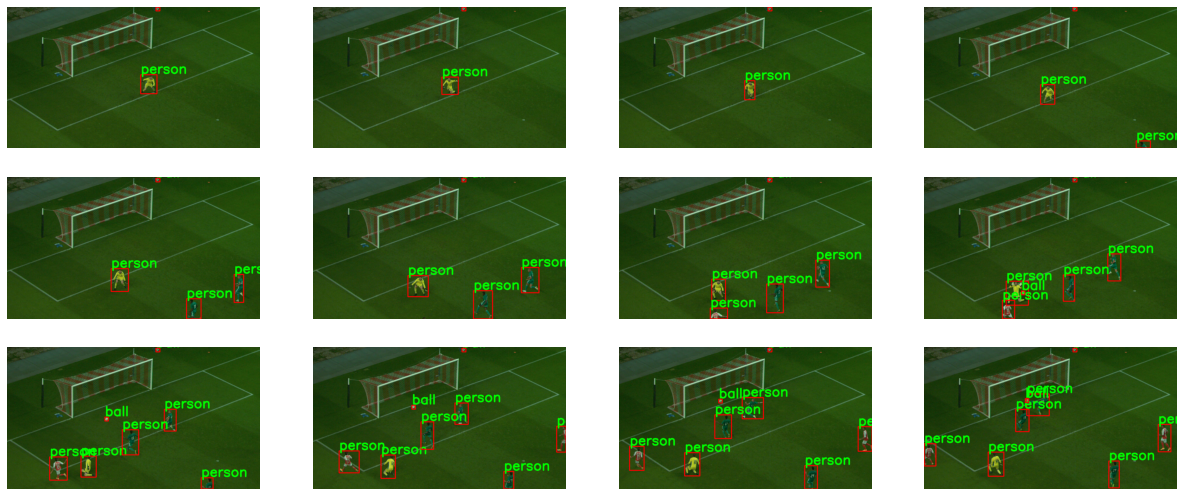

In [10]:
plot(
    image_paths=os.path.join(data_folder,'images/train/*'),
    label_paths=os.path.join(data_folder,'labels/train/*'),
    num_samples=12,
)

# Training

Prepare a folder to be used as "context" for the training task.

In [11]:
# This should point to Yolov5 cloned repository (https://github.com/ultralytics/yolov5)
script_folder = os.path.join(os.getcwd(), "..\\src\\yolov5")
script_folder

'd:\\Projects\\Innovation.NGDG.BodyTrackingPoC\\notebooks\\..\\src\\yolov5'

### Cloud environment

Run the following cell to define the execution environment in the cloud compute instance

In [ ]:
# From a pip requirements file
env = Environment.from_pip_requirements(name = "cloud-env", file_path = os.path.join(script_folder, "requirements.txt"))

# Register environment to re-use later
env.register(workspace = ws)

### Local compute target

Run the following cell to execute the training script locally. The script will run in the local Python environment, so please configure all the required dependencies.

In [12]:
env = Environment("local-env")
env.python.user_managed_dependencies = True
env.python.interpreter_path = os.path.join(os.getcwd(), "..\\.venv38\\Scripts\python.exe")

### Define the AzureML training pipeline

Use the following settings if training locally:

In [49]:
compute_target = "local"
dataset_path_val = "D:/Users/Gianni/Downloads/yolov5_gt_dataset"

Use the following settings if training in the cloud:

In [ ]:
dataset = Dataset.File.from_files(path=(datastore, 'datasets/yolov5_soccer'))
dataset_path_val = dataset.as_named_input('input').as_mount()

In [44]:
data_val = './soccer.yaml'
weights_val = 'yolov5m.pt'
img_val = 640
epochs_val = 100
batch_size_val = 16
name_val = 'exp'
project_val = './outputs'

In [47]:
src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      compute_target=compute_target,
                      environment=env,
                      arguments=['--data', data_val, '--dataset_mount_path', dataset_path_val, '--weights', weights_val, '--img', img_val, '--epochs', epochs_val, '--batch-size', batch_size_val, '--project', project_val, '--name', name_val])

Assign the compute target to the pipeline (if running in the cloud):

In [ ]:
src.run_config.target = compute_target

Run the experiment

In [48]:
run = exp.submit(config=src)
run.wait_for_completion(show_output=True)

RunId: yolov5_custom_training_1651783786_2bad5cdc
Web View: https://ml.azure.com/runs/yolov5_custom_training_1651783786_2bad5cdc?wsid=/subscriptions/35d018a1-fd64-4a56-91e9-75f463fbfd0d/resourcegroups/rg-ngdg-explorations/workspaces/ws-ngdg-explorations&tid=c0ce862b-4b4e-4e97-8074-1579f52f12d3

Streaming azureml-logs/70_driver_log.txt

[2022-05-05T20:49:49.701280] Entering context manager injector.
[2022-05-05T20:49:51.126870] context_manager_injector.py Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['train.py', '--data', './soccer.yaml', '--dataset_mount_path', 'D:/Users/Gianni/Downloads/yolov5_gt_dataset', '--weights', 'yolov5m.pt', '--img', '640', '--epochs', '100', '--batch-size', '16', '--project', './outputs', '--name', 'exp'])
Script type = None
[2022-05-05T20:49:51.134769] Entering Run History Context Manager.
[2022-05-05T20:4

{'runId': 'yolov5_custom_training_1651783786_2bad5cdc',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2022-05-05T20:49:49.072142Z',
 'endTimeUtc': '2022-05-05T21:04:53.452745Z',
 'services': {},
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '3272312c-c57e-4354-be38-ef7b14edc093',
  'azureml.git.repository_uri': 'https://alm.deltatre.it/tfs/D3Alm/Innovation.NGDG.BodyTrackingPoC/_git/Innovation.NGDG.BodyTrackingPoC',
  'mlflow.source.git.repoURL': 'https://alm.deltatre.it/tfs/D3Alm/Innovation.NGDG.BodyTrackingPoC/_git/Innovation.NGDG.BodyTrackingPoC',
  'azureml.git.branch': 'tino/task/272363-yolo5-custom-training',
  'mlflow.source.git.branch': 'tino/task/272363-yolo5-custom-training',
  'azureml.git.commit': 'e13f789801f5a92fced097b05479ae0b5de8e9b7',
  'mlflow.source.git.commit': 'e13f789801f5a92fced097b05479ae0b5de8e9b7',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'train.py'

When training is completed, we can download the trained model:

In [51]:
run.download_file("outputs/exp/weights/best.pt", "../src/yolov5/yolov5m_custom.pt")

To be used in the inference demo app, the model can be converted to ONNX format.  
From within the virtual environment, from `src/yolov5` folder, launch:

`python export.py --weights yolov5m_custom.pt --imgsz 640 640 --include onnx`

the ONNX model will be saved in the same folder, and can then be used in ML.NET.